<a href="https://colab.research.google.com/github/coddmajes/deep-learning/blob/master/Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Sequential
import tensorflow as tf
import numpy as np
import logging
logging.getLogger('temsorflow').disabled = True


In [2]:
if tf.test.is_gpu_available():
  print("The following GPU devices are avaliable: %s" % tf.test.gpu_device_name())
  !/usr/bin/nvidia-smi -L

The following GPU devices are avaliable: /device:GPU:0
GPU 0: Tesla K80 (UUID: GPU-63cb099c-19c6-e6fa-7f4a-8fab97af7b44)


Data preparation

In [3]:
!wget --no-check-certificate --show-progress -q\
    "https://github.com/tsakailab/prml/raw/master/ChestXray/chest_xray_150x150.zip" \
    -O "/tmp/chest_xray_150x150.zip"


/tmp/chest_xray_150 100%[===================>]  23.37M   105MB/s    in 0.2s    


In [0]:
import zipfile
import os
zip_ref = zipfile.ZipFile("/tmp/chest_xray_150x150.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

root_dir = "/tmp/chest_xray_150x150"

class_names = os.listdir(root_dir + "/train")




In [5]:

train, test, val = {}, {}, {}
train_files, test_files, val_files = {}, {}, {}
for class_name in class_names:
  train_files[class_name] = os.listdir(root_dir + "/train/" + class_name)
  test_files[class_name] = os.listdir(root_dir + "/test/" + class_name)
  val_files[class_name] = os.listdir(root_dir + "/val/"+ class_name)
print("#training data: %s" % ([(k, len(v) )for (k,v) in train_files.items()]))
print("#test data: %s" % ([(k, len(v) )for (k,v) in test_files.items()]))
print("#val data: %s" % ([(k, len(v) )for (k,v) in val_files.items()]))

train['files'], test['files'], val['files'] = train_files, test_files, val_files

#training data: [('NORMAL', 1349), ('PNEUMONIA', 3875)]
#test data: [('NORMAL', 234), ('PNEUMONIA', 390)]
#val data: [('NORMAL', 8), ('PNEUMONIA', 8)]


data augementation

In [0]:
preprocess_input = lambda x: x/127.5-1.

train['gen'] = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 1,
    width_shift_range = 0.,
    height_shift_range = 0.,
    horizontal_flip = False
)

test['gen'] = ImageDataGenerator(preprocessing_function= preprocess_input)
val['gen'] = ImageDataGenerator(preprocessing_function= preprocess_input)


In [25]:
train['dir'] = root_dir + "/train"
test['dir'] = root_dir + "/test"
val['dir'] = root_dir + "/val"

target_size = (150,150)
batch_size = 128

train['flow'] = train['gen'].flow_from_directory(train['dir'],
                                                 class_mode = "binary",
                                                 target_size = target_size,
                                                 batch_size = batch_size)
cid_to_class_name = {train['flow'].class_indices[name] : name for name in class_names}

num_data = {k: len(v) for (k,v) in train['files'].items()}
max_num_data = max(num_data.values())
class_weight = {train['flow'].class_indices[name]: max_num_data/num_data[name] for name in class_names}

test['flow'] = test['gen'].flow_from_directory(test['dir'],
                                               class_mode = "binary",
                                               target_size = target_size)
val['flow'] = val['gen'].flow_from_directory(val['dir'],
                                             class_mode = "binary",
                                             target_size = target_size)


Found 5224 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


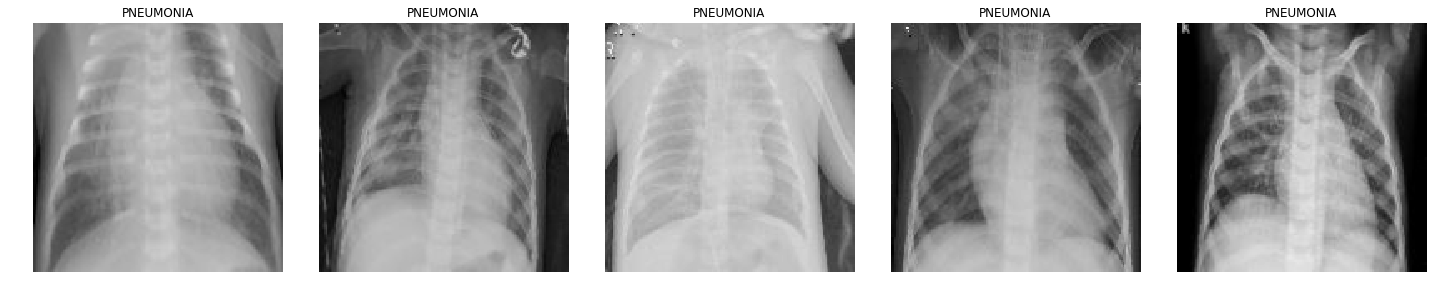

In [17]:
import matplotlib.pyplot as plt
def plotImage( img_arr, lbl_arr):
  fig, axes = plt.subplots(1, min(len(img_arr),5), figsize = (20,20))
  axes = axes.flatten()
  for img, lbl, ax in zip(img_arr, lbl_arr, axes):
    ax.imshow(img[:,:,0], cmap = 'gray', vmin = -1, vmax =1)
    ax.title.set_text(cid_to_class_name[lbl])
    ax.axis('off')
  plt.tight_layout()
  plt.show()

image_batch, label_batch = next(train['flow'])
plotImage(image_batch, label_batch)


In [0]:
model = tf.keras.models.Sequential([                  
            tf.keras.layers.Conv2D(64, (3,3), activation='relu',input_shape= (target_size[0], target_size[1],3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Flatten(),
            #tf.keras.layers.Dense(512, activation= 'relu'),
            tf.keras.layers.Dense(2, activation= 'softmax') #output 

])

回调函数

In [0]:
DESIRED_TRAIN_ACCURACY = 0.99
DESIRED_VAL_ACCURACY = 0.85

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>DESIRED_TRAIN_ACCURACY and logs.set('val_acc')>DESIRED_VAL_ACCURACY):
      print("\nReached %.f accuracy and %.f val accuracy." %(DESIRED_TRAIN_ACCURACY*100, DESIRED_VAL_ACCURACY*100))
      self.model.stop_training = True
callbacks = myCallback()

In [0]:
model.compile(optimizer= 'adam', loss="sparse_categorical_crossentropy",metrics=['accuracy'])

In [24]:
history = model.fit_generator(train['flow'], epochs = 6, validation_data=val['flow'], callbacks=[callbacks])

Epoch 1/6
82/82 [==============================] - 33s 401ms/step - loss: 0.2287 - acc: 0.9075 - val_loss: 0.7240 - val_acc: 0.6250
Epoch 2/6
82/82 [==============================] - 31s 383ms/step - loss: 0.0988 - acc: 0.9636 - val_loss: 0.6169 - val_acc: 0.6875
Epoch 3/6
82/82 [==============================] - 32s 388ms/step - loss: 0.0802 - acc: 0.9705 - val_loss: 0.3339 - val_acc: 0.7500
Epoch 4/6
82/82 [==============================] - 32s 388ms/step - loss: 0.0595 - acc: 0.9765 - val_loss: 0.2331 - val_acc: 0.8750
Epoch 5/6
82/82 [==============================] - 32s 387ms/step - loss: 0.0582 - acc: 0.9791 - val_loss: 0.3839 - val_acc: 0.7500
Epoch 6/6
82/82 [==============================] - 32s 387ms/step - loss: 0.0459 - acc: 0.9830 - val_loss: 0.2249 - val_acc: 0.9375


/usr/local/lib/python3.6/dist-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "low right". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


AttributeError: ignored

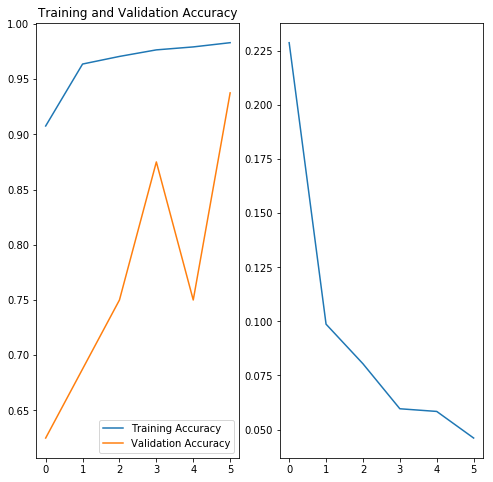

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(loss))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc='low right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss,label='Training Loss')
plt.plot(epochs_range,val_loss,labe='Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.show()


In [27]:
score = model.evaluate(test['flow'])
print('Test Loss: {:3f}, Test Accuracy : {:2f}'.format(score[0],score[1]))
num_test = {k: len(v) for (k,v) in test['files'].items()}
print('Chance rate of PNEUMONIA: %.2f' % (num_test['PNEUMONIA']/sum(num_test.values())))

20/20 [==============================] - 1s 36ms/step - loss: 1.3522 - acc: 0.7564
Test Loss: 1.352172, Test Accuracy : 0.756410
Chance rate of PNEUMONIA: 0.62


Model predictions (blue: correct, red: incorrect)


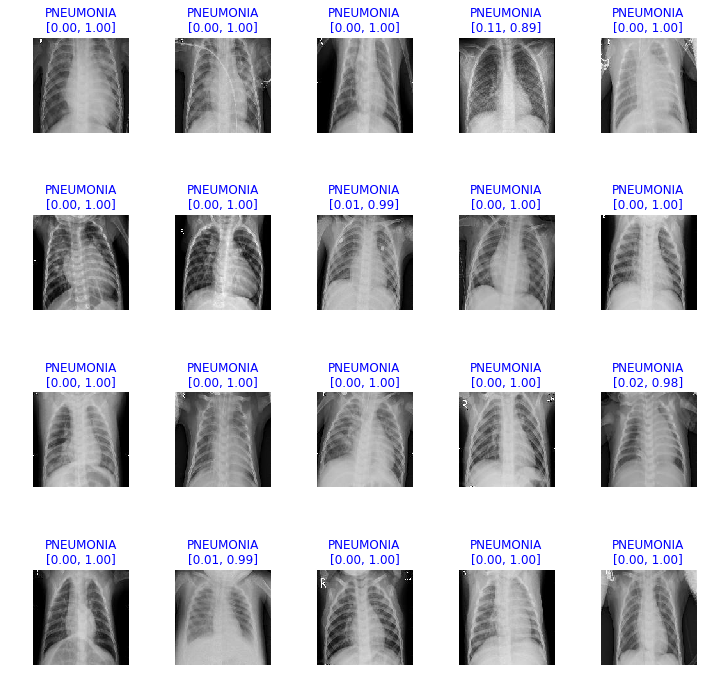

In [28]:
dataset = test
#class_name = 'NOMAL'
class_name = 'PNEUMONIA'


from time import time
rng = np.random.RandomState(int(time()))
ids = rng.choice(len(dataset['files'][class_name]),20,replace = False)

print("Model predictions (blue: correct, red: incorrect)")
fig,axes = plt.subplots(4,5, figsize = (10,10))
axes = axes.flatten()
for data_id, ax in zip(ids, axes):
  gt_class_name = class_name
  file = dataset['files'][gt_class_name][data_id]
  img_in = load_img(dataset['dir'] + '/' + gt_class_name + '/' + file, target_size= target_size)
  x = preprocess_input(np.expand_dims(img_to_array(img_in), axis=0))
  pred = model.predict(x)
  cid_pred = np.argmax(pred[0])
  pred_class_name = cid_to_class_name[cid_pred]

  ax.imshow(img_in, cmap='gray', vmin=-1, vmax=1)
  ax.axis('off')
  ax.set_title(pred_class_name+'\n[%.2f, %.2f]' % (pred[0][0], pred[0][1]), color='blue' if pred_class_name == gt_class_name else 'red')

plt.tight_layout()
plt.show()


Visualizing all feature maps for an image of the class NORMAL in training dataset


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Ground truth: NORMAL [0.98788303 0.0121169 ]  Predicted label: NORMAL


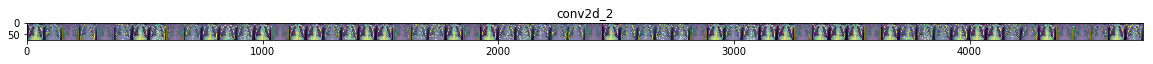

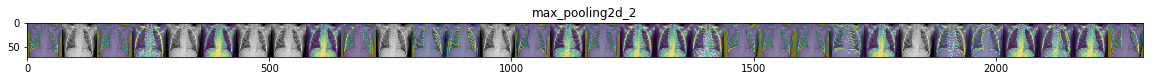

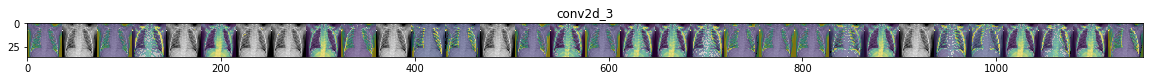

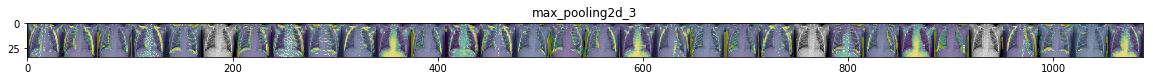

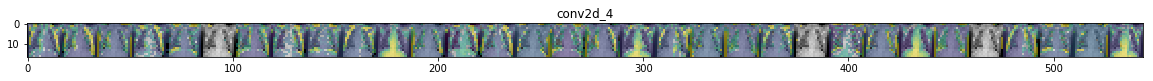

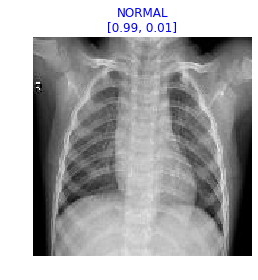

In [29]:
dataset = test  # train, val, test
class_name = 'NORMAL'
#class_name = 'PNEUMONIA'

gt_class_name = class_name

import numpy as np
import random

print("Visualizing all feature maps for an image of the class %s in training dataset" % (class_name))
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

file = random.choice(dataset['files'][class_name])
img_in = load_img(dataset['dir'] + '/' + gt_class_name + '/' + file, target_size=target_size)
x = preprocess_input(np.expand_dims(img_to_array(img_in), axis=0))
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))
        maps_min = feature_map[0,:,:,:].min()
        maps_max = feature_map[0,:,:,:].max()
        for i in range(n_features):
            y = feature_map[0, :, :, i]
            y -= y.mean()
            if n_features > 2:
                y /= y.std()
                y *= 64
                y += 128
            else:
                y = (y - maps_min) / (maps_max - maps_min) * 255
            y = np.clip(y, 0, 255)
            y[(y > 118) & (y < 138)] = np.nan
            display_grid[:, i * size : (i + 1) * size] = y
            
        if n_features > 2:
            scale = 20. / n_features
        else:
            scale = 4.
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(np.tile(np.array(img_in.resize((size,size))), (1, n_features, 1)), aspect='auto', cmap='gray')
        plt.gca().imshow(display_grid, aspect='auto', alpha=0.5, cmap='viridis') #cmap='jet')

pred = model.predict(x)
cid_pred = np.argmax(pred[0])
pred_class_name = cid_to_class_name[cid_pred]
print("Ground truth: " + gt_class_name + " " + str(pred[0]) + "  Predicted label: " + pred_class_name)
plt.figure()
plt.imshow(img_in, cmap='gray', vmin=-1, vmax=1)
plt.axis('off')
plt.title(pred_class_name + '\n[%.2f, %.2f]' % (pred[0][0], pred[0][1]), 
          color='blue' if pred_class_name == gt_class_name else 'red')
plt.tight_layout()
plt.show()
